<a href="https://colab.research.google.com/github/msiddhu/iedc-diabetic-project/blob/master/3_resnet50_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This Notebook Uses ReSNet50 (Transfer Learning with PreTrained Weights and Retraining) Model to generate Output Predictions

#  <font color='red'>Table of Contents</font>


[9. ResNet50 Models](#section9)<br>


In [ ]:
# Research Kernel Link - https://github.com/dimitreOliveira/APTOS2019BlindnessDetection/blob/master/Model%20backlog/ResNet50/4%20-%20ResNet50%20-%20Batch%20size%2022.ipynb
 
import pandas as pd
import numpy as np
import os
from prettytable import PrettyTable
import pickle
import multiprocessing
from multiprocessing.pool import ThreadPool
print(multiprocessing.cpu_count()," CPU cores")
 
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
 
from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
 
from PIL import Image
import cv2
 
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
 
# Colab Libs...
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

#  <a id = 'section9'> <font color='red'>  9. ResNet50 Models  </font> </a>

### <font color='red'> 9.1 Setup Colab Environment </font>

In [ ]:
def load_data():
    train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
    #test = pd.read_csv('test.csv')
    
    train_dir = os.path.join('../','input/diabetic-retinopathy-resized/resized_train/resized_train/')
    #test_dir = os.path.join('./','test_images/')
    
    train['file_path'] = train['image'].map(lambda x: os.path.join(train_dir,'{}.jpeg'.format(x)))
    #test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir,'{}.jpeg'.format(x)))
    
    train['file_name'] = train["image"].apply(lambda x: x + ".jpeg")
    #test['file_name'] = test["id_code"].apply(lambda x: x + ".jpeg")
    
    train['level'] = train['level'].astype(str)
    
    return train


In [106]:
from sklearn.model_selection import train_test_split
df_train = load_data()
print(df_train.shape,'\n')
df_train.head(6)
df_train,df_test =train_test_split(df_train,test_size = 0.1)
df_train_train,df_train_test =train_test_split(df_train,test_size = 0.2)

print(df_train_train.shape,df_train_test.shape,df_test.shape)

(35126, 4) 

(25290, 4) (6323, 4) (3513, 4)


In [ ]:
df_train.head(6)

In [ ]:
# def load_data():
#     file = open('df_train_train', 'rb')
#     df_train_train = pickle.load(file)
#     file.close()

#     file = open('df_train_test', 'rb')
#     df_train_test = pickle.load(file)
#     file.close()
    
#     return df_train_train,df_train_test

### <font color='red'> 9.2 Image Pre Processing </font>

In [ ]:
IMG_SIZE = 512

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def preprocess_image(img):
   # print(os.path.join('../input/diabetic-retinopathy-resized/',file))
    #input_filepath = os.path.join('../input/diabetic-retinopathy-resized/',file)
    #img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    #img= cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (IMG_SIZE,IMG_SIZE))
    img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    return img

### <font color='red'> 9.3 Train Model </font>

In [ ]:
# Model parameters
BATCH_SIZE = 32
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 512
WIDTH = 512
CANAL = 3
N_CLASSES = df_train_train['level'].nunique()
ES_PATIENCE = 10
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [117]:
def img_generator(train,valid,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True,preprocessing_function=preprocess_image)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="../input/diabetic-retinopathy-resized/resized_train/resized_train/",
                                                      x_col="file_name",
                                                      y_col="level",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train_test,
                                                      directory="../input/diabetic-retinopathy-resized/resized_train/resized_train/",
                                                      x_col="file_name",
                                                      y_col="level",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess_image)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                       directory = "../input/diabetic-retinopathy-resized/resized_train/resized_train/",
                                                       x_col="file_name",
                                                       target_size=(HEIGHT, WIDTH),
                                                       batch_size=1,
                                                       shuffle=False,
                                                       class_mode=None)
    
    return train_generator,valid_generator,test_generator

In [118]:
train_generator,valid_generator,test_generator= img_generator(df_train_train,df_train_test,df_test)

Found 20232 validated image filenames belonging to 5 classes.
Found 1264 validated image filenames belonging to 5 classes.
Found 3513 validated image filenames.


In [113]:
s=next(train_generator)

In [ ]:
s=cv2.imread('../input/diabetic-retinopathy-resized/resized_train/resized_train/10009_left.jpeg')
s=preprocess_image(s)

import matplotlib.pyplot as plt
plt.imshow(s)

In [ ]:

def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)

    base_model = applications.ResNet50(weights='imagenet', include_top=False,input_tensor=input_tensor)
 

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model

In [ ]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
model.summary()

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

In [ ]:
model.compile(optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy',metrics = ['accuracy'])

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

In [ ]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,save_best_only=True, mode='auto', period=1)
callback_list = [rlrop,es,checkpoint]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'],callbacks=callback_list)
model.summary()

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          verbose=1).history

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
from keras.models import load_model

model.load_weights('model.h5')


In [ ]:
# ref - https://stackoverflow.com/questions/29188757/matplotlib-specify-format-of-floats-for-tick-lables
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [ ]:
# file = open('df_test', 'rb')
# df_test = pickle.load(file)
# file.close()


### <font color='red'> 9.4 Generate Train Predictions on complete Train Data </font>

In [ ]:
complete_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess_image)
complete_generator = complete_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                          directory = '../input/diabetic-retinopathy-resized/resized_train/resized_train/',
                                                          x_col='file_name',
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None,)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)
train_preds = [np.argmax(pred) for pred in train_preds]

In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, df_train_train['level'].astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(df_train_train['level'].astype('int'),train_preds))

### <font color='red'> 9.5 Evaluate Model on Test Data </font>

In [119]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

3513/3513 [==============================] - 277s 79ms/step


In [124]:
print(test_labels[1])
print(test_preds[1])

2
[0.03858653 0.05231638 0.55489653 0.23266652 0.12153406]


In [125]:
print("test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df_test['level'].astype('int'), weights='quadratic'))
print("test Accuracy score : %.3f" % accuracy_score(df_test['level'].astype('int'),test_labels))

Train Cohen Kappa score: 0.224
Train Accuracy score : 0.758


In [126]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)
    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    #sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.show()

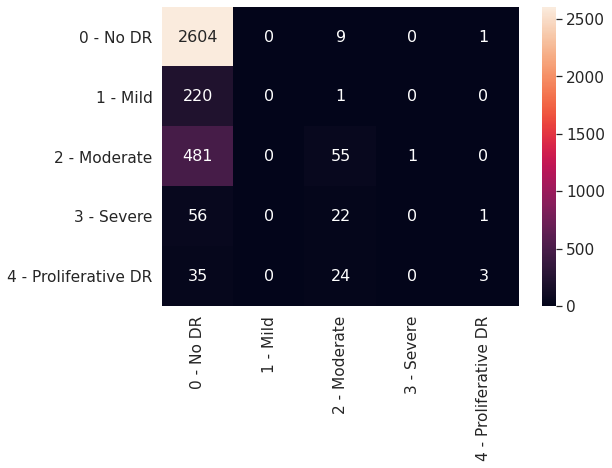

In [127]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(df_test['level'].astype(int)),test_labels,labels)

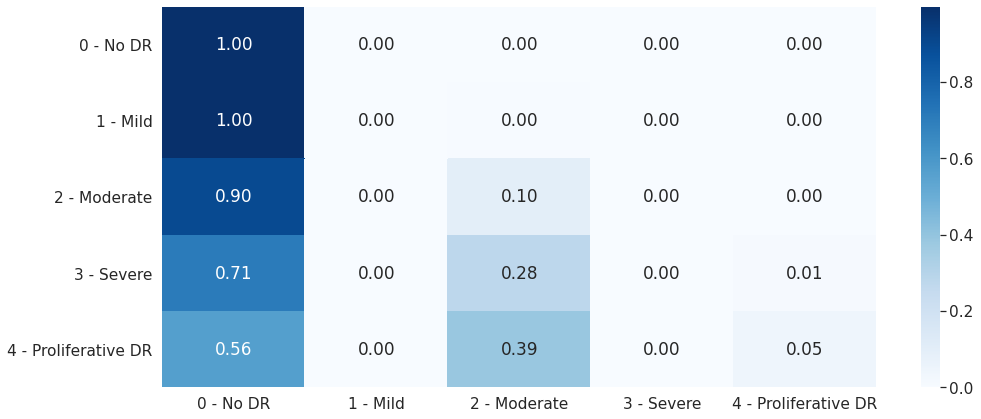

In [128]:
cnf_matrix = confusion_matrix(df_test['level'].astype('int'), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [131]:
# print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df_test['level'].astype('int'), weights='quadratic'))
# print("Test Accuracy score : %.3f" % accuracy_score(df_test['level'].astype('int'),test_labels))

Test Cohen Kappa score: 0.224
Test Accuracy score : 0.758


### <font color='red'> 9.6 ResNet50 Models Summary </font>

In [133]:
#x = PrettyTable()
#x.field_names = ["S.No.","ResNet50 Model","Image Processing","Data Augmentation","Hyperparameters(BS,Opt,lr,ep)","Train QWK","Test QWK"]

# x.add_row([1,"R-P-D-p(0.5)-D-p(0.5)-S(5)","--","Hor Flip,Scale 1/255","(4,'Adam','1e-4',7)","0.912","0.905"])
# x.add_row([2,"R-P-D-p(0.5)-D-p(0.5)-S(5)","Circle Crop, Gaussian Blur","Hor Flip,Scale 1/255","(4,'Adam','1e-4',7)","0.98","0.904"])

# print(x)

+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
| S.No. |       ResNet50 Model       |      Image Processing      |  Data Augmentation   | Hyperparameters(BS,Opt,lr,ep) | Train QWK | Test QWK |
+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
|   1   | R-P-D-p(0.5)-D-p(0.5)-S(5) |             --             | Hor Flip,Scale 1/255 |      (4,'Adam','1e-4',7)      |   0.912   |  0.905   |
|   2   | R-P-D-p(0.5)-D-p(0.5)-S(5) | Circle Crop, Gaussian Blur | Hor Flip,Scale 1/255 |      (4,'Adam','1e-4',7)      |    0.98   |  0.904   |
+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
